In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import importlib

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import torch as th
import torch_geometric as pyg

import pandas as pd
import pickle

import LPGNN

2022-11-01 01:49:26.527483: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 01:49:26.527524: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
importlib.reload(LPGNN.popularity_similarity)
importlib.reload(LPGNN.poincare_embedding)
importlib.reload(LPGNN.distances)
importlib.reload(LPGNN.LinkPrediction)
importlib.reload(LPGNN.DataSetup)

<module 'LPGNN.DataSetup' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/DataSetup.py'>

In [4]:
def gromov(G):
    node_tuple = np.random.choice(G.nodes(), 4, replace=False)
    try:
        d01 = nx.shortest_path_length(G, source=node_tuple[0], target=node_tuple[1], weight=None)
        d23 = nx.shortest_path_length(G, source=node_tuple[2], target=node_tuple[3], weight=None)
        d02 = nx.shortest_path_length(G, source=node_tuple[0], target=node_tuple[2], weight=None)
        d13 = nx.shortest_path_length(G, source=node_tuple[1], target=node_tuple[3], weight=None)
        d03 = nx.shortest_path_length(G, source=node_tuple[0], target=node_tuple[3], weight=None)
        d12 = nx.shortest_path_length(G, source=node_tuple[1], target=node_tuple[2], weight=None)

        s = [d01 + d23, d02 + d13, d03 + d12]
        s.sort()
        return (s[-1] - s[-2]) / 2
    except Exception as e:
        print('No shortest path')
        return None

def sample_hyperbolicity(G, num_samples=5000):
    hyps = []
    for i in range(num_samples):
        hyps.append(gromov(G))

    return np.mean(hyps)

In [5]:
N = 500
avg_k = 6
gamma = 2.7

In [8]:
T = np.linspace(0, 4, 20)
AVG_K = [4, 8, 10, 12]
GAMMA = np.linspace(2, 3, 11)
reps = 2

for gamma in GAMMA:
    for avg_k in AVG_K:
        hyps = []
        for t in T:
            _ = 0
            for rep in range(reps):
                print(f'\rgamma = {gamma:.2f}, avg_k = {avg_k:02}, T = {t:.2f}, rep = {rep:02}', end='')
                PS = LPGNN.popularity_similarity.generatePSNetwork(N, avg_k, gamma, T=t, seed=t*reps)
                PS_nx = nx.Graph((pyg.utils.to_networkx(PS)), undirected=True)
                _ += sample_hyperbolicity(PS_nx)
            hyps.append(_/reps)
        with open(f'../data/Hyperbolicity/g_vs_T_N_{N}_avg_k_{avg_k}_gamma_{gamma}.hyp', 'wb') as f:
            pickle.dump([T, hyps], f)

gamma = 3.00, avg_k = 12, T = 4.00, rep = 01

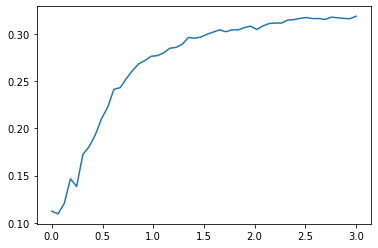

In [27]:
plt.plot(T, hyps)